In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt

from pydrake.solvers import MathematicalProgram, Solve
import pydrake.symbolic as sym



In [2]:
import sympy as sp

In [3]:
t, p0x, p1x, p2x, p3x, p0y, p1y, p2y, p3y = sp.symbols('t p_{0x} p1x p2x p3x p0y p1y p2y p3y')
b3x = p0x*(1-t)**3 + p1x*3*(1-t)**2*t + p2x*3*(1-t)*t**2 + p3x*t**3
b3y = p0y*(1-t)**3 + p1y*3*(1-t)**2*t + p2y*3*(1-t)*t**2 + p3y*t**3

In [4]:
b3x.collect(p0x).collect(p1x).collect(p2x).collect(p3x)

3*p1x*t*(1 - t)**2 + 3*p2x*t**2*(1 - t) + p3x*t**3 + p_{0x}*(1 - t)**3

In [5]:
# from scipy.sparse import coo_matrix
# import numpy as np
# from pydrake.all import MathematicalProgram, Solve, eq
# from scipy.sparse.csgraph import dijkstra
# from scipy.sparse import lil_matrix 
from dijkstraspp import DijkstraSPP
# class DijkstraSPP:
#     def __init__(self, regions, verbose = True):
#         self.verbose = verbose
#         self.safe_sets = []
#         self.safe_adjacencies = []
#         self.regions = [r for r in regions]
#         for id1, r1 in enumerate(regions):
#             for id2, r2 in enumerate(regions):
#                 if id1 != id2 and id1 < id2:
#                     if r1.IntersectsWith(r2):
#                         self.safe_sets.append(r1.Intersection(r2))
#                         self.safe_adjacencies.append([id1, id2])
                        
#         reppts = np.array([s.ChebyshevCenter() for s in self.safe_sets])
        
#         safe_ad = lil_matrix((len(self.safe_sets), len(self.safe_sets)))
#         for id in range(len(regions)):
#             safeset_idxs_in_region_id = np.where([id in s for s in self.safe_adjacencies])[0]
#             for i,id1 in enumerate(safeset_idxs_in_region_id[:-1]):
#                 for id2 in safeset_idxs_in_region_id[i:]:     
#                     safe_ad[id1, id2] = 1
#                     safe_ad[id2, id1] = 1
                    
#         #optimize_reppts
#         prog = MathematicalProgram()
#         repopt = prog.NewContinuousVariables(*reppts.shape)
#         for i, s in enumerate(self.safe_sets):
#             s.AddPointInSetConstraints(prog, repopt[i,:])

#         for i in range(len(self.safe_sets)):
#             for j in range(i+1, len(self.safe_sets)):
#                 if safe_ad[i,j]==1:
#                     prog.AddCost(np.linalg.norm(repopt[i,:]- repopt[j,:]))
#         result = Solve(prog)
#         print(result.is_success())
#         self.reppts = result.GetSolution(repopt)
#         dist_mat = lil_matrix((len(self.safe_sets), len(self.safe_sets)))
#         for i in range(len(self.safe_sets)):
#             for j in range(i+1, len(self.safe_sets)):
#                 if safe_ad[i,j]==1:
#                     dist = np.linalg.norm(self.reppts[i,:]- self.reppts[j,:])
#                     dist_mat[i,j] = dist_mat[j,i] = dist
#         self.dist_mat = dist_mat.tocoo()
    
#     def solve(self, 
#               start,
#               target,
#               refine_path = True):
#         ad_mat = self.extend_adjacency_mat(start, target)
#         if ad_mat is not None:
#             wps, dist = self.dijkstra_in_configspace(adj_mat=ad_mat)
#             if dist<0:
#                 print('[DijkstraSPP] Points not reachable')
#                 return [], -1
#             if refine_path:
#                 location_wps_optimized, dist_optimized = self.refine_path_SOCP(wps, 
#                                                                         start, 
#                                                                         target, 
#                                                                         )
#                 return location_wps_optimized, dist_optimized
            
#             intermediate_nodes = [self.reppts[idx, :] for idx in wps[1:-1]]
#             waypoints = [start] + intermediate_nodes + [target]
#             return waypoints, dist
#         else:
#             print('[DijkstraSPP] Points not in regions')
#             return [], -1


#     def dijkstra_in_configspace(self, adj_mat):
#         # convention for start and target: source point is second to last and target is last point
#         src = adj_mat.shape[0] -2
#         target = adj_mat.shape[0] -1
#         dist, pred = dijkstra(adj_mat, directed=False, indices=src, return_predecessors=True)
#         #print(f'{len(np.argwhere(pred == -9999))} disconnected nodes'), #np.argwhere(pred == -9999))
#         idxs = (pred == -9999)
#         pred[idxs] = -1000000
#         dist[idxs] = -1000000
#         sp_list = []
#         sp_length = dist[target]
#         if sp_length<0:
#             return [], sp_length
#         current_idx = target
#         sp_list.append(current_idx)
#         while not current_idx == adj_mat.shape[0] - 2:
#             current_idx = pred[current_idx]
#             sp_list.append(current_idx)
#             if current_idx==src: break
#         return [idx for idx in sp_list[::-1]], sp_length


#     def extend_adjacency_mat(self, start, target):
#         #first check point memberships
#         start_idx = []
#         target_idx = []
#         for idx, r in enumerate(self.regions):
#             if r.PointInSet(start):
#                 start_idx.append(idx)
#             if r.PointInSet(target):
#                 target_idx.append(idx)
#         if len(start_idx)==0 or len(target_idx)==0:
#             print('[DijkstraSPP] Points not in set, idxs', start_idx,', ', target_idx)
#             return None
#         N = self.dist_mat.shape[0] + 2
#         data = list(self.dist_mat.data)
#         rows = list(self.dist_mat.row)
#         cols = list(self.dist_mat.col)
#         start_adj_idx = N-2
#         target_adj_idx = N-1
#         for id in start_idx:
#             safeset_idxs_in_region_id = np.where([id in s for s in self.safe_adjacencies])[0]
#             for idx in safeset_idxs_in_region_id:
#                 dist = np.linalg.norm(start - self.reppts[idx, :])
#                 data.append(dist)
#                 rows.append(start_adj_idx)
#                 cols.append(idx)
#                 data.append(dist)
#                 rows.append(idx)
#                 cols.append(start_adj_idx)
#         for id in target_idx:
#             safeset_idxs_in_region_id = np.where([id in s for s in self.safe_adjacencies])[0]
#             for idx in safeset_idxs_in_region_id:
#                 dist = np.linalg.norm(target - self.reppts[idx, :])
#                 data.append(dist)
#                 rows.append(target_adj_idx)
#                 cols.append(idx)
#                 data.append(dist)
#                 rows.append(idx)
#                 cols.append(target_adj_idx)
#         if len(list(set(start_idx)& set(target_idx))):
#             dist = np.linalg.norm(target - start)
#             data.append(dist)
#             rows.append(target_adj_idx)
#             cols.append(start_adj_idx)
#             data.append(dist)
#             rows.append(start_adj_idx)
#             cols.append(target_adj_idx)     
            
#         ad_mat_extend = coo_matrix((data, (rows, cols)), shape=(N, N))
#         return ad_mat_extend
    
#     def refine_path_SOCP(self, wps, start, target):
#             #intermediate_nodes = [self.node_intersections[idx] for idx in wps[1:-1]]
#             dim = len(start)
#             prog = MathematicalProgram()
#             wps = np.array(wps)
            
#             int_waypoints = prog.NewContinuousVariables(len(wps[1:-1]), dim)
#             for i, wp in enumerate(wps[1:-1]):
#                 self.safe_sets[wp].AddPointInSetConstraints(prog, int_waypoints[i,:])
            
#             prev = start
#             cost = 0 
#             for idx in range(len(wps[1:-1])):
#                 t = prog.NewContinuousVariables(dim+1, 't'+str(idx))
#                 prog.AddConstraint(eq(t[1:], prev-int_waypoints[idx]))
#                 prev = int_waypoints[idx]
#                 prog.AddLorentzConeConstraint(t)
#                 cost += t[0]
#             t = prog.NewContinuousVariables(dim+1, 'tend')
#             prog.AddConstraint(eq(t[1:], prev-target))
#             prog.AddLorentzConeConstraint(t)
#             cost += t[0]
#             prog.AddCost(cost)

#             res = Solve(prog)
#             if res.is_success():
#                 path = [start]
#                 for i in res.GetSolution(int_waypoints):
#                     path.append(i)
#                 path.append(target)
#                 wps_start = [self.reppts[idx] for idx in wps[1:-1]]
#                 dist_start = 0
#                 prev = start
#                 for wp in wps_start + [target]:
#                     #dist_start += np.linalg.norm()#* np.array([4.0,3.5,3,2.5,2,2.5,1])
#                     a = prev-wp
#                     dist_start += np.sqrt(a.T@a)
#                     prev = wp
#                 if self.verbose: print("[DijkstraSPP] optimized distance/ start-distance = {opt:.2f} / {start:.2f} = {res:.2f}".format(opt = res.get_optimal_cost(), start = dist_start, res = res.get_optimal_cost()/dist_start))
#                 return path, res.get_optimal_cost()
#             else:
#                 print("[DijkstraSPP] Refine path SCOP failed")
#                 return None, None

/home/peter/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.17.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [15]:
from pydrake.all import HPolyhedron
import numpy as np
from visualization_utils import plot_HPoly
import matplotlib.pyplot as plt

points = np.array([[0,-0.8],[-5,5]])
points = np.array([[3,-2],[-5,5]])
center_points = np.array([[0, 0],
                          [1.3, 1.4],
                          [2.2, 4.2],
                          [-1.6, 1],
                          [-3,3.7],
                          [-4.2, 5],
                          [0,6],
                          [0,3.7]])

sizes = np.array([[1,2],
                  [2,2],
                  [0.5,5.],
                  [3,1],
                  [1,5],
                  [2.2,2],
                  [6,0.3],
                  [0.8,5]])

from visibility_utils import point_in_regions
regions =[]
for c, s in zip(center_points, sizes):
    l = c- s/2
    u = c + s/2
    regions.append(HPolyhedron.MakeBox(l,u))


sizes = np.array([[1,4],
                  [1,3],
                  #[2,2],
                  ])

center_points = np.array([[-2, 3.5],
                          [1.3, 4],
                          #[1.6, 1.4],
                          ])

obstacles = []
for c, s in zip(center_points, sizes):
    l = c- s/2
    u = c + s/2
    obstacles.append(HPolyhedron.MakeBox(l,u))

class checker:
    def __init__(self, obstacles):
        self.obstacles = [o for o in obstacles]
        self.res = 0.01
    
    def CheckEdgeCollisionFreeParallel(self, a, b):
        tv = np.arange(0,1,self.res)
        for t in tv:
            pt = t*b + (1-t)*a
            if point_in_regions(pt, self.obstacles):
                return False
        return True
    
col_check = checker(obstacles)
dspp = DijkstraSPP(regions, col_check, verbose=True)

[DijkstraSPP] Pre-Building adjacency matrix  0 / 8
[DijkstraSPP] Pre-Building safe-adjacency matrix  0 / 8
True


[DijkstraSPP] Attempting visibility extension
[DijkstraSPP] optimized distance/ start-distance = 11.01 / 11.24 = 0.98
[DijkstraSPP] Attempting visibility extension


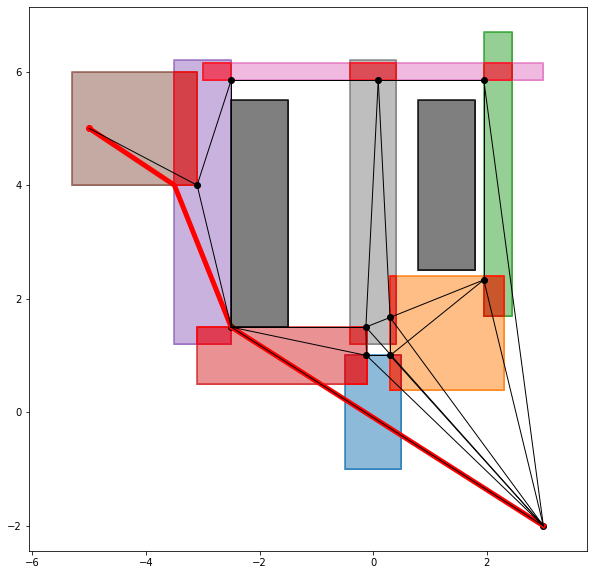

In [17]:
wps, dist = dspp.solve(points[0], points[1], refine_path=True)
wps = np.array(wps)
ad_coo, fixed_idx = dspp.extend_adjacency_mat(points[0], points[1])
ad_dense = ad_coo.toarray()
reppoints_tot = np.concatenate((dspp.reppts, np.array(points)), axis = 0)
fig, ax = plt.subplots(figsize = (10,10))
for p,c in zip(points, ['k','r']):
    ax.scatter(p[0], p[1], c = c)
ax.axis('equal')
for r in regions:
    plot_HPoly(ax, r)
for r in dspp.safe_sets:
    plot_HPoly(ax, r, color = 'r')

for r in obstacles:
    plot_HPoly(ax, r, color = 'k', zorder=10)

for i in range(len(dspp.safe_sets)+1):
    for j in range(i+1, len(dspp.safe_sets)+2):
        if ad_dense[i,j]!=0:
            x = [reppoints_tot[i][0], reppoints_tot[j][0]]
            y = [reppoints_tot[i][1], reppoints_tot[j][1]]
            ax.plot(x,y, linewidth = 1, c = 'k',zorder =10)
ax.scatter(dspp.reppts[:,0], dspp.reppts[:,1], c = 'k')
ax.plot(wps[:,0], wps[:, 1], linewidth = 5 , c = 'r')


In [8]:
col_check.CheckEdgeCollisionFreeParallel(np.array([3,2]), np.array([-4,2]))

True

In [14]:
a = np.array([3,2])
b = np.array([-4,2])

tv = np.arange(0,1,0.1)
for t in tv:
    pt = t*b + (1-t)*a
    if point_in_regions(pt, obstacles):
        print( False)

False


In [13]:
tv

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [8]:
regions[0].PointInSet()

TypeError: PointInSet(): incompatible function arguments. The following argument types are supported:
    1. (self: pydrake.geometry.optimization.ConvexSet, x: numpy.ndarray[numpy.float64[m, 1]], tol: float = 1e-08) -> bool

Invoked with: <pydrake.geometry.optimization.HPolyhedron object at 0x7fa6c346b670>

In [46]:
from dijkstraspp import DijkstraSPPsolver
def conv(q):
    return q
dspp = DijkstraSPPsolver(regions, conv)
wps, _ = dspp.solve(points[0], points[1], refine_path=True)
for i in range(len(wps)-1):
    ax.plot([wps[i][0], wps[i+1][0]], [wps[i][1], wps[i+1][1]], c = 'k', linewidth = 1)


array([ 0. , -0.8])

([array([ 0. , -0.8]),
  array([-0.3,  0.8]),
  array([-2.65,  1.35]),
  array([-3.45,  5.95]),
  array([-5.,  5.])],
 10.528398645080689)

In [40]:
b3diff= sp.diff(b3, t)
b3diffexp = sp.expand(b3diff)
b3diffexp.collect(p0).collect(p1).collect(p2).collect(p3)

p0*(-3*t**2 + 6*t - 3) + p1*(9*t**2 - 12*t + 3) + p2*(-9*t**2 + 6*t) + 3*p3*t**2

In [42]:
b3ddiff= sp.diff(b3diffexp, t)
b3ddiffexp = sp.expand(b3ddiff)
b3ddiffexp.collect(p0).collect(p1).collect(p2).collect(p3)

p0*(6 - 6*t) + p1*(18*t - 12) + p2*(6 - 18*t) + 6*p3*t

In [43]:
b3dddiff= sp.diff(b3ddiffexp, t)
b3dddiffexp = sp.expand(b3dddiff)
b3dddiffexp.collect(p0).collect(p1).collect(p2).collect(p3)

-6*p0 + 18*p1 - 18*p2 + 6*p3

In [12]:
def sort_terms_by_power(poly):
    # Get the terms of the polynomial
    terms = sp.Add.make_args(poly)
    
    # Sort the terms by their powers of 't'
    terms.sort(key=lambda term: sp.Poly(term, domain=sp.EX).as_dict().get(t, 0))

    # Create a new polynomial with the sorted terms
    sorted_poly = sp.Add(*terms)

    return sorted_poly

sort_terms_by_power(b3diffexp)

AttributeError: 'tuple' object has no attribute 'sort'

In [30]:
terms =list(sp.Add.make_args(b3diffexp))
sp.collect(b3, t)


p0*(1 - t)**3 + 3*p1*t*(1 - t)**2 + 3*p2*t**2*(1 - t) + p3*t**3

In [37]:
terms[3].has(t**3)


False


-9*p2*t**2

In [6]:
prog = MathematicalProgram()
# Declares indeterminates
t = prog.NewIndeterminates(1,'t')
p0 = prog.NewContinuousVariables(1, 'p0')
p1 = prog.NewContinuousVariables(1, 'p1')
p2 = prog.NewContinuousVariables(1, 'p2')
p3 = prog.NewContinuousVariables(1, 'p3')



In [7]:
exp = (1-t)**3*p0 + 3*(1-t)**2*t*p1 + 3*(1-t)*t**2*p2 + 3*t**2*p3 

array([<Expression "(3 * (t(0) * p1(0) * pow((1 - t(0)), 2)) + 3 * (pow(t(0), 2) * p2(0) * (1 - t(0))) + 3 * (pow(t(0), 2) * p3(0)) + (p0(0) * pow((1 - t(0)), 3)))">],
      dtype=object)